In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
import h5py
import datetime
import os
import sys


## Get Model

In [10]:
from runet_torch import runet

model = runet()
print(model)

runet(
  (enc1): EncoderBlock(
    (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (enc2): EncoderBlock(
    (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (enc3): EncoderBlock(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (enc4): EncoderBlock(
    (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (enc5): EncoderBlock(
    (conv): Conv2d(64, 128, kernel_size=(3, 3), stride

## Custom Dataset

In [11]:
# Define dataset
class HDF5Dataset(Dataset):
    def __init__(self, hdf5_file_path):
        self.hf_r = h5py.File(hdf5_file_path, 'r')
        self.data_x = self.hf_r['k']
        self.data_y = self.hf_r['S']

    def __len__(self):
        return self.data_x.shape[0]  # Assuming N is the first dimension

    def __getitem__(self, idx):
        sample_x = self.data_x[idx, :, :, :]  # Extract a single item for k
        sample_y = self.data_y[idx, :, :, :]  # Extract the corresponding item for S

        
        #sample_x, sample_y = self.transform(sample_x, sample_y)

        return sample_x, sample_y
    
    def transform(sample_x, sample_y):
        sample_x = np.transpose(sample_x, (2, 3, 0, 1))
        sample_y = np.transpose(sample_x, (2, 3, 0, 1))
        return sample_x, sample_y


## Hyperparameters

In [12]:
# Hyperparameters
batch_size = 8
learning_rate = 0.0001
weight_decay = 0.00001
epochs = 1

# Create instances of dataset and dataloaders
data_dir = './'

# Train
train_dataset = HDF5Dataset(data_dir + 'train_200000_reshaped.hdf5')
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Test / Validation
test_dataset = HDF5Dataset(data_dir + 'test_30400_reshaped.hdf5')
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Initialize loss function
criterion = nn.MSELoss()

# Optimizer
no_decay = []
decay = []

for name, param in model.named_parameters():
    # Get Conv2d kernels without bias and last output Conv2d
    if 'conv' in name and 'weight' in name:
        decay.append(param)
    else:
        no_decay.append(param)

parameters = [
    {'params': no_decay},
    {'params': decay, 'weight_decay': weight_decay}
]

optimizer = optim.Adam(parameters, lr=learning_rate)


In [13]:
# Check conv modules
conv_modules = [module for name, module in model.named_modules() if 'conv' in name]

print(*conv_modules, sep='\n')

Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), paddin

## Support log functions

In [23]:
def _iter_log(work_dirs, filename, epoch, batch, loss):
    # Open the log file in append mode
    with open(work_dirs+filename, "a") as log_file:    
        
        # Training steps (epoch, batch, loss)
        #loss_result = str(loss).replace("{","").replace("}", "")
        formatted_losses = ', '.join([f'{key}: {value}' for key, value in loss.items()])

        log_file.write(f"Epoch: {epoch}, Batch: {batch}, {formatted_losses}\n")
        print(f"Epoch: {epoch}, Batch: {batch}, {formatted_losses}\n")

        # Add a separator for better readability
        #log_file.write("\n" + "-" * 20 + "\n")

def _save_log(work_dirs, filename, name):
    current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Open the log file in append mode
    with open(work_dirs+filename, "a") as log_file:    
        log_file.write("\n" + "=" * 20 + "\n")

        # Save information (if provided)
        log_file.write(f"\nModel Saved: ")
        log_file.write(f"Time: {current_time}\t")
        log_file.write(f"Name: {name}\n")
        #log_file.write(f"Path: {save_info['path']}\n")

        # Add a separator for better readability
        log_file.write("\n" + "=" * 20 + "\n")

def _init_log(work_dirs, filename):
    if not os.path.exists(work_dirs):
        # If it doesn't exist, create it
        os.makedirs(work_dirs)

    # Open the log file in append mode
    with open(work_dirs+filename, "a") as log_file:
        # Python, CUDA, and Torch versions
        log_file.write(f"Python Version: {sys.version}\n")
        log_file.write(f"CUDA Availability: {torch.cuda.is_available()}\n")
        log_file.write(f"PyTorch Version: {torch.__version__}\n\n")
        # Add a separator for better readability
        log_file.write("\n" + "-" * 20 + "\n")

        # Model structure
        log_file.write("Model Structure:\n")
        log_file.write(f"{model}\n\n")
        # Add a separator for better readability
        log_file.write("\n" + "-" * 20 + "\n")


## Loss function

In [18]:
def mean_plume_error(input_tensor, target_tensor):
    # Calculate absolute differences along the channel dimension
    abs_diff = torch.abs(input_tensor - target_tensor)

    # Mask out zero values to consider only non-zero values
    non_zero_mask = input_tensor != 0
    abs_diff_non_zero = abs_diff[non_zero_mask]

    # Calculate the sum of absolute differences for each image
    sum_abs_diff_per_image = abs_diff_non_zero.view(input_tensor.size(0), -1).sum(dim=1)

    # Count the number of non-zero elements for each image
    num_nonzero_elements_per_image = non_zero_mask.view(input_tensor.size(0), -1).sum(dim=1)

    # Calculate the mean plume error for each image
    mean_plume_error_per_image = sum_abs_diff_per_image / num_nonzero_elements_per_image

    # Calculate the overall mean plume error across all images
    overall_mean_plume_error = mean_plume_error_per_image.mean()

    return overall_mean_plume_error

def root_mse(mse_loss):
    return torch.sqrt(torch.tensor(mse_loss))

## Train

In [24]:
# Add training logs
work_dirs = "./work_dirs/"
current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
log_filename = f"log_{current_time}.txt"
_init_log(work_dirs, log_filename)


# Training loop
for epoch in range(epochs):
    model.train()
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        
        inputs = inputs.to(torch.float32)
        targets = targets.to(torch.float32)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print progress
        if batch_idx % 100 == 0:
            #print(f'Epoch [{epoch + 1}/{epochs}], Step [{batch_idx}/{len(train_loader)}], formatted_losses')
            # MSE, RMSE, MPE for monitoring purpose
            RMSE = root_mse(loss.item())
            MPE = mean_plume_error(outputs, targets)
            vis_loss = {'MSE': f"{loss.item():.5f}", 'RMSE': f"{RMSE:.5f}", 'MPE': f"{MPE:.5f}"}

            # Iteration log
            _iter_log(work_dirs, log_filename, f'[{epoch + 1}/{epochs}]', f'[{batch_idx}/{len(train_loader)}]', vis_loss)


    # Save the trained model
    torch.save(model.state_dict(), f'{work_dirs}epoch_{epoch}.pth')
    _save_log(work_dirs, log_filename, f'{work_dirs}epoch_{epoch}.pth')

    # Optionally, add a validation loop
    # ...

# Save the trained model
#torch.save(model.state_dict(), f'{work_dirs}epoch{epoch}.pth')
#_save_log(work_dirs, log_filename, f'{work_dirs}epoch_{epoch}.pth')

Epoch: [1/1], Batch: [0/25000], MSE: 0.00786, RMSE: 0.08865, MPE: 0.05858

Epoch: [1/1], Batch: [100/25000], MSE: 0.00431, RMSE: 0.06566, MPE: 0.04263

Epoch: [1/1], Batch: [200/25000], MSE: 0.00283, RMSE: 0.05317, MPE: 0.03309

Epoch: [1/1], Batch: [300/25000], MSE: 0.00388, RMSE: 0.06232, MPE: 0.03340

Epoch: [1/1], Batch: [400/25000], MSE: 0.00287, RMSE: 0.05353, MPE: 0.03155

Epoch: [1/1], Batch: [500/25000], MSE: 0.00533, RMSE: 0.07299, MPE: 0.03560

Epoch: [1/1], Batch: [600/25000], MSE: 0.00228, RMSE: 0.04780, MPE: 0.02537

Epoch: [1/1], Batch: [700/25000], MSE: 0.00196, RMSE: 0.04428, MPE: 0.02290

Epoch: [1/1], Batch: [800/25000], MSE: 0.00292, RMSE: 0.05401, MPE: 0.02626

Epoch: [1/1], Batch: [900/25000], MSE: 0.00154, RMSE: 0.03925, MPE: 0.01951

Epoch: [1/1], Batch: [1000/25000], MSE: 0.00282, RMSE: 0.05309, MPE: 0.02447

Epoch: [1/1], Batch: [1100/25000], MSE: 0.00342, RMSE: 0.05850, MPE: 0.02804

Epoch: [1/1], Batch: [1200/25000], MSE: 0.00185, RMSE: 0.04299, MPE: 0.02013

KeyboardInterrupt: 

## Test

In [26]:
inputs, targets  = test_dataset[:10]
        
inputs = torch.tensor(inputs, dtype=torch.float32)
targets = torch.tensor(targets, dtype=torch.float32)

# Forward pass
outputs = model(inputs)

In [27]:
print(inputs.shape)
print(targets.shape)
print(outputs.shape)

torch.Size([10, 3, 128, 128])
torch.Size([10, 1, 128, 128])
torch.Size([10, 1, 128, 128])


## Visualization

<Figure size 432x288 with 0 Axes>

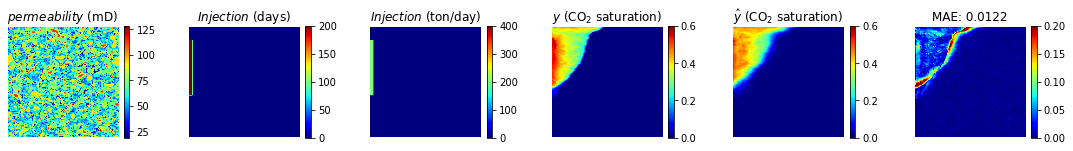

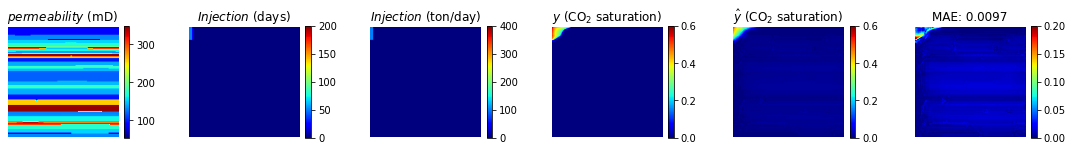

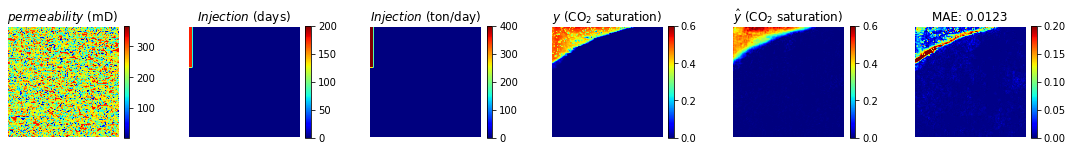

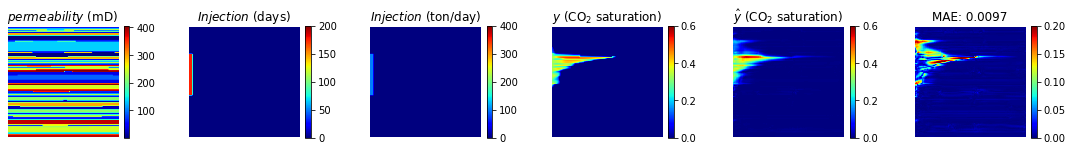

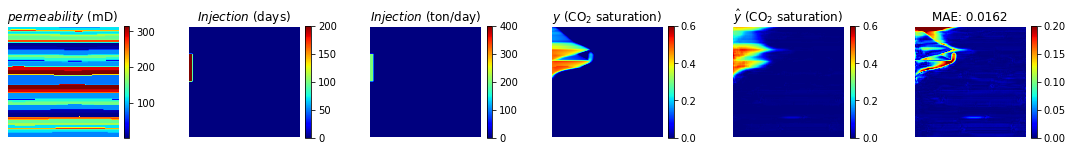

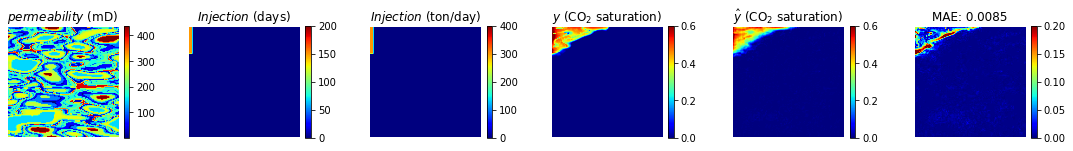

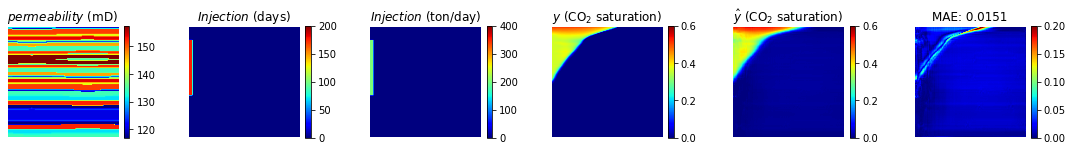

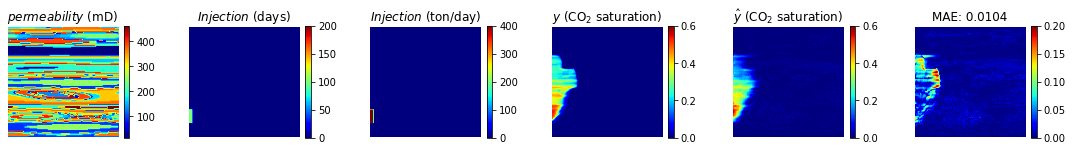

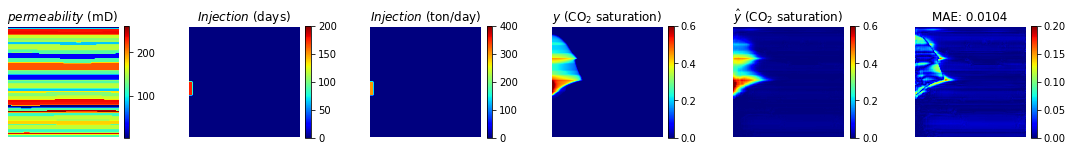

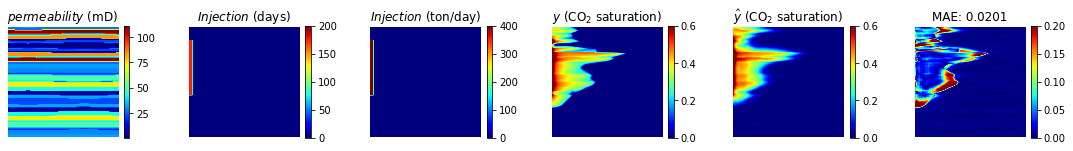

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.set_cmap('jet')
for k in range(0,10):
    plt.figure(k,figsize=(15,3))
    
    plt.subplot(1,6,1)
    plt.title('$permeability$ (mD)')
    plt.imshow(inputs[k, 0, :, :] * 1000)
    plt.colorbar(fraction=0.046)
    plt.axis('off')
    
    plt.subplot(1,6,2)
    plt.title('$Injection$ (days)')
    plot_day = inputs[k, 1, :, :]*200
    plot_day[:,1:4] = plot_day[:,0].reshape(128,1)
    plt.imshow(plot_day)
    plt.clim([0, 200])
    plt.colorbar(fraction=0.046)
    plt.axis('off')
    
    plt.subplot(1,6,3)
    plt.title('$Injection$ (ton/day)')
    plot_rate = inputs[k, 2, :, :]*400
    plot_rate[:,1:4] = plot_rate[:,0].reshape(128,1)
    plt.imshow(plot_rate)
    plt.clim([0, 400])
    plt.colorbar(fraction=0.046)
    plt.axis('off')
    
    plt.subplot(1,6,4)
    plt.title('$y$ (CO$_2$ saturation)')
    plt.imshow(targets[k, 0, :, :].reshape(128, 128))
    plt.clim([0, 0.6])
    plt.colorbar(fraction=0.046)
    plt.axis('off')
    
    plt.subplot(1,6,5)
    plt.imshow(outputs[k, 0, :, :].detach().cpu().numpy().reshape(128, 128))
    plt.title('$\hat{y}$ (CO$_2$ saturation)')
    plt.clim([0, 0.6])
    plt.colorbar(fraction=0.046)
    plt.axis('off')
    
    plt.subplot(1,6,6)
    abs_err = np.abs((outputs[k, 0, :, :] - targets[k, 0, :, :]).detach().cpu().numpy())
    plt.imshow(abs_err) 
    mean_err = np.mean(abs_err)
    plt.title('MAE: %.4f' % mean_err)
    plt.colorbar(fraction=0.046)
    plt.clim([0, 0.2])
    plt.tight_layout()
    plt.axis('off')
    plt.show()
